In [247]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import netCDF4 as nc
from pyproj import Proj, Transformer, CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import plotly as py
from plotly.graph_objs import *
from scipy.io import netcdf
from mpl_toolkits.basemap import Basemap
import plotly.express as px
import plotly.graph_objects as go
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units
import seaborn as sns
from osgeo import gdal
from shapely.geometry import Point
import scipy as sp
import rasterio
from utils_exploration import *
from elevation_point_query import *

In [2]:
geo_ts = GeoTsObject()

In [3]:
dataset = geo_ts.read_netcdf(as_dataframe=False)


## Conversions

In [4]:
# Conversions (see MetPy). 

dataset['precipitation_mmh'] = dataset['rainfall_flux_kgms'].assign(Precip = (dataset['rainfall_flux_kgms'].Rainf + dataset['snowfall_flux_kgms'].Snowf) * 3600)
dataset['pressure_hpa'] = dataset['pressure_pa'].assign(PSurf_hpa = dataset['pressure_pa'].PSurf * 0.01)

# Alternative to MetPy. Order matters here, don't change

# g_0 = 2.8365744*10**3
# g_1 = 6.028076559*10**3
# g_2 = 1.954263612*10
# g_3 = -2.737830188*10**-2
# g_4 = 1.6261698*10**-5
# g_5 = 7.0229056*10**-10
# g_6 = -1.8680009*10*-13
# g_7 = 2.7150305


# qair = qair.assign(Sat_vap_pres = pow(np.exp, (np.sum(g_0*temp.Tair + g_1*temp.Tair + g_2*temp.Tair + g_3*temp.Tair + g_4*temp.Tair +
#                                             g_5*temp.Tair + g_6*temp.Tair) + g_7* np.log(temp.Tair))))

# qair = qair.assign(Mixing_ratio = 0.622 * qair.Sat_vap_pres/ (psurf.PSurf_hpa - qair.Sat_vap_pres))

# rel_hum = qair.assign(Rel_hum = qair.Qair / ((1 - qair.Qair)* qair.Mixing_ratio))

dataset['temperature_degc'] = dataset['temperature_K'].assign(Tair_degc = dataset['temperature_K'].Tair - 273.15)


# rel_hum = qair.assign(Rel_hum = relative_humidity_from_specific_humidity(
#                         psurf.PSurf_hpa.values * units.hPa, 
#                         temp.Tair_degc.values * units.degC, 
#                         qair.Qair.values).to('percent').magnitude)

In [5]:
variable_names = dataset.keys()
variable_names

dict_keys(['pressure_pa', 'specific_humidity_kgkg', 'rainfall_flux_kgms', 'snowfall_flux_kgms', 'temperature_K', 'shortwave_down_wm', 'wind_speed_ms', 'precipitation_mmh', 'pressure_hpa', 'temperature_degc'])

# Resampling

In [6]:
#forcings_daily = resample(forcing_datasets, variable_names, 'D')

In [7]:
forcings_monthly = resample(dataset, 'M')

Cannot resample pressure_pa
Cannot resample rainfall_flux_kgms
Cannot resample snowfall_flux_kgms
Cannot resample temperature_K


In [8]:
#forcings_yearly = resample(forcing_datasets, variable_names, 'Y')

In [8]:
#forcings_seasonally = resample(dataset, 'season')

# Exploring the data set

## Monthly mean

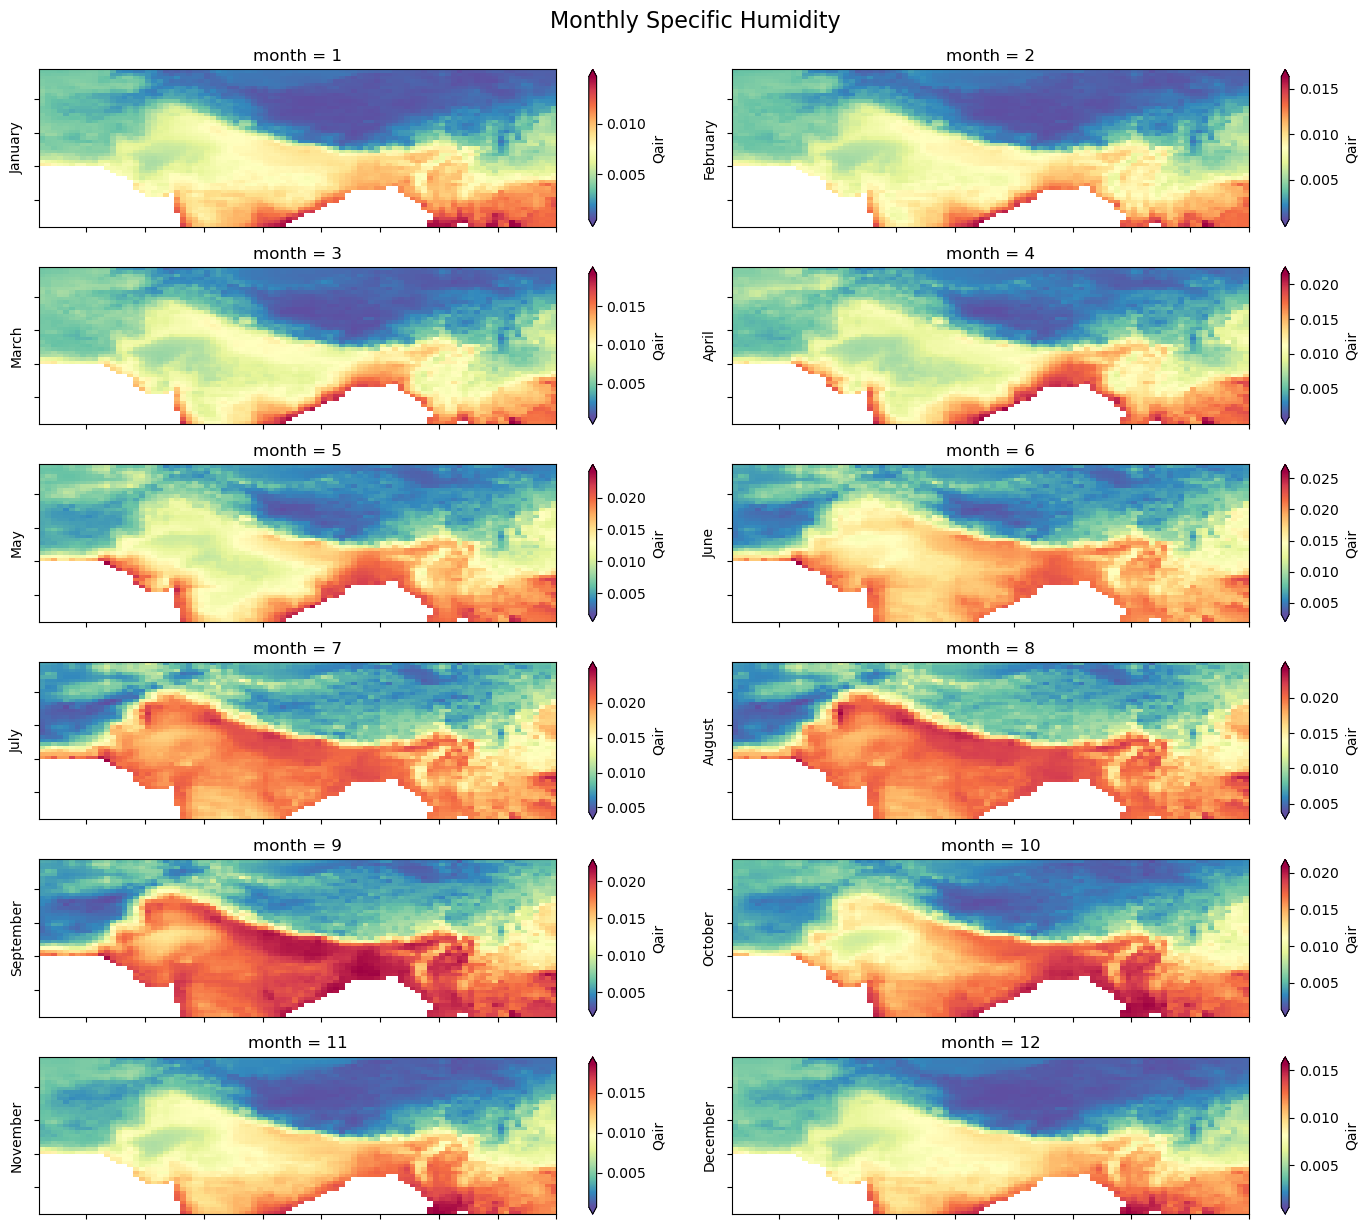

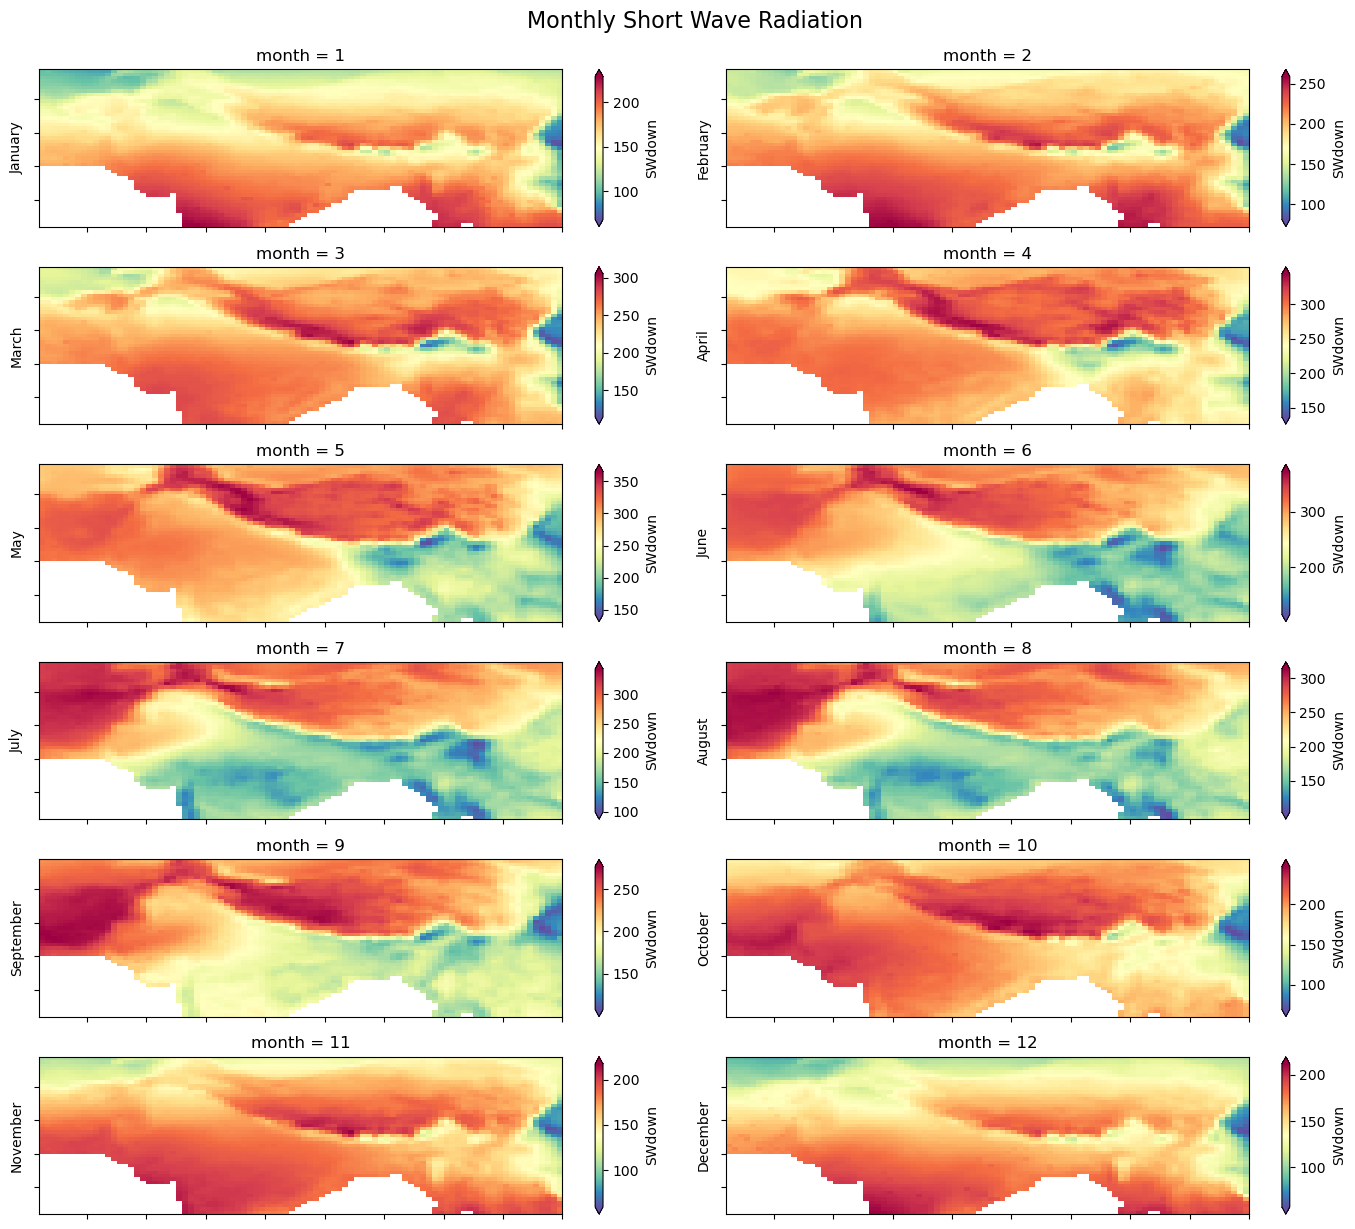

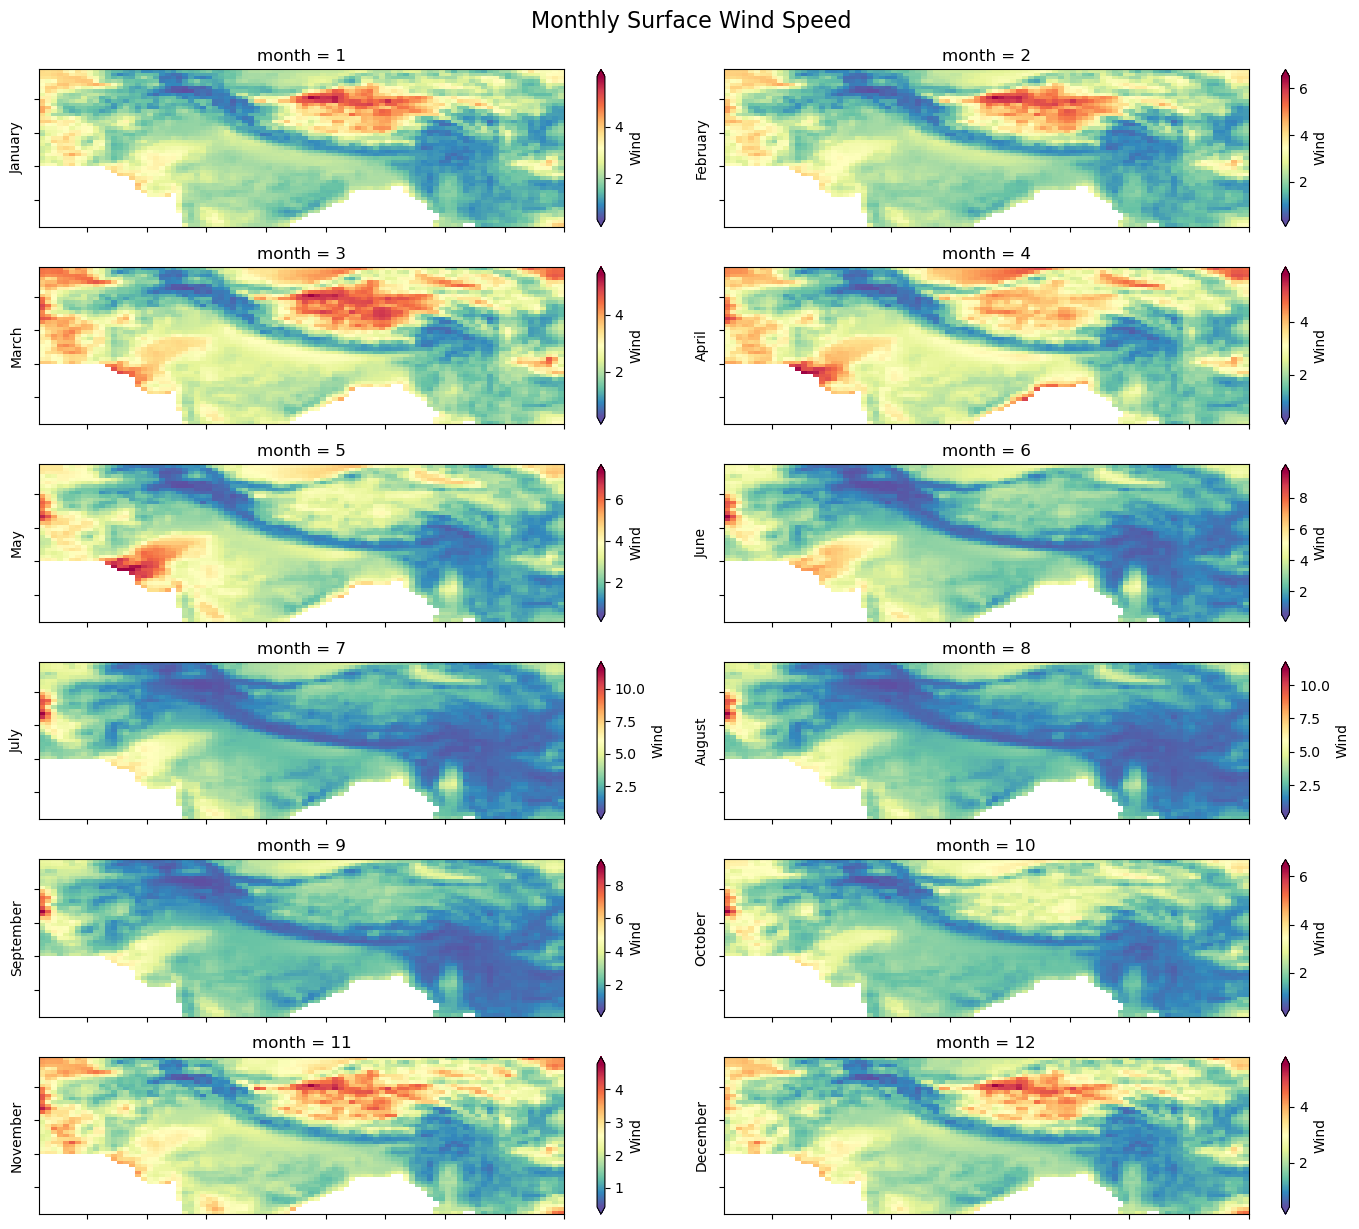

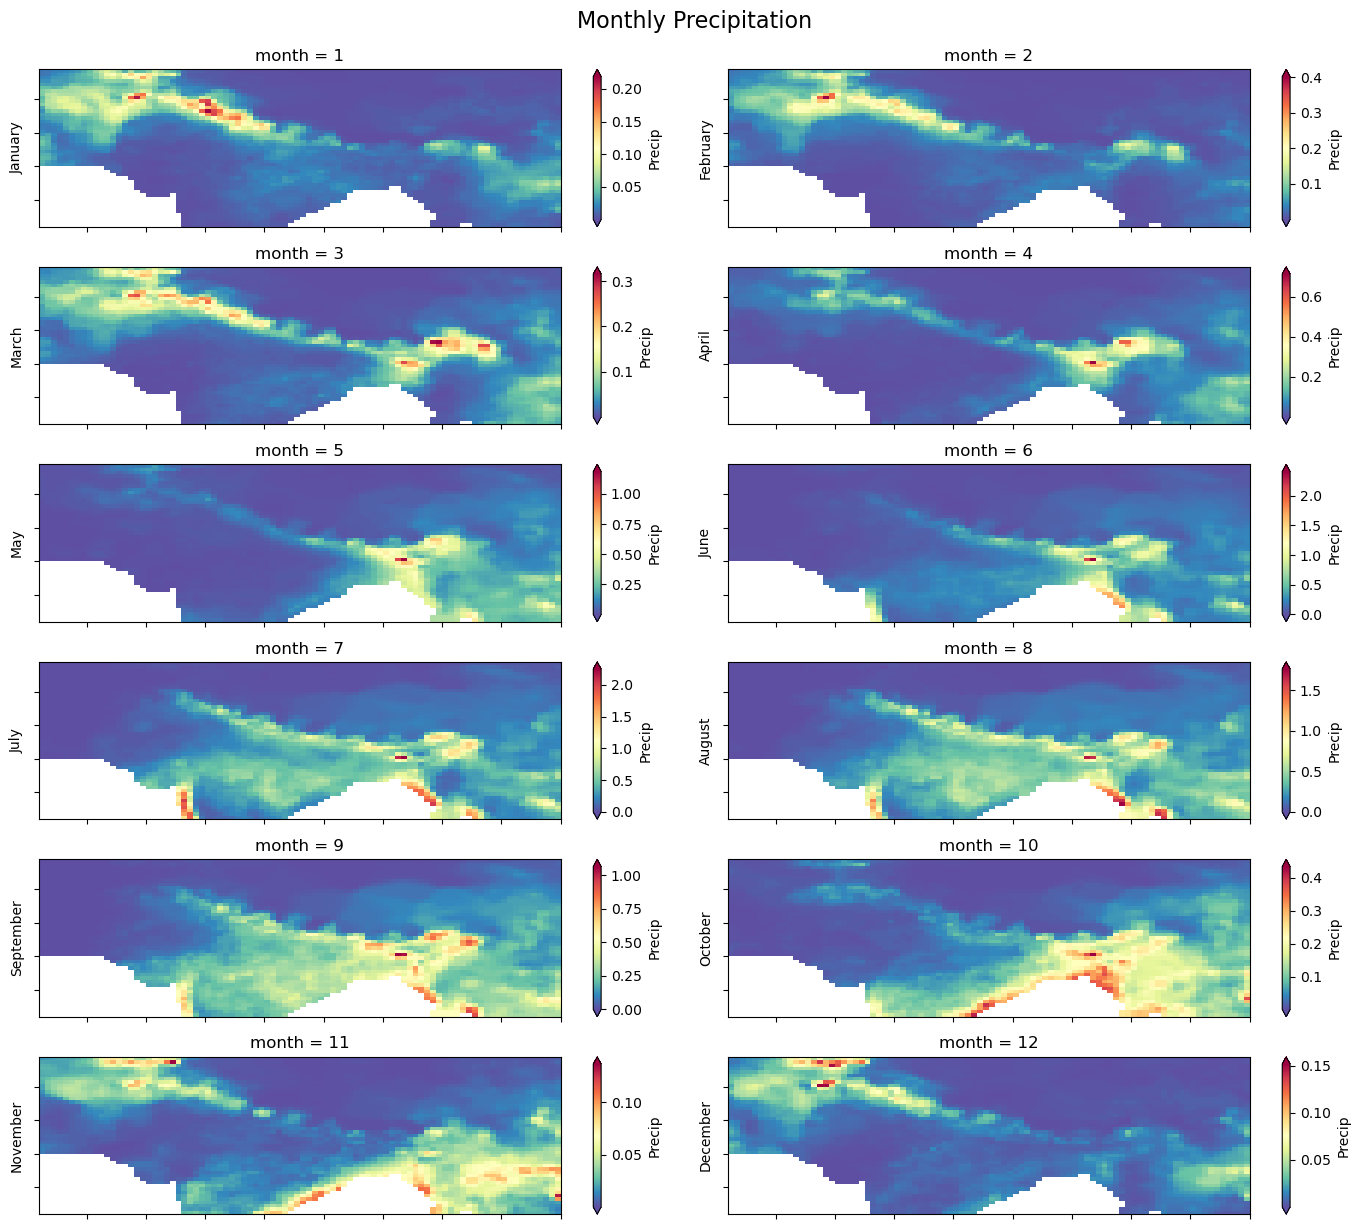

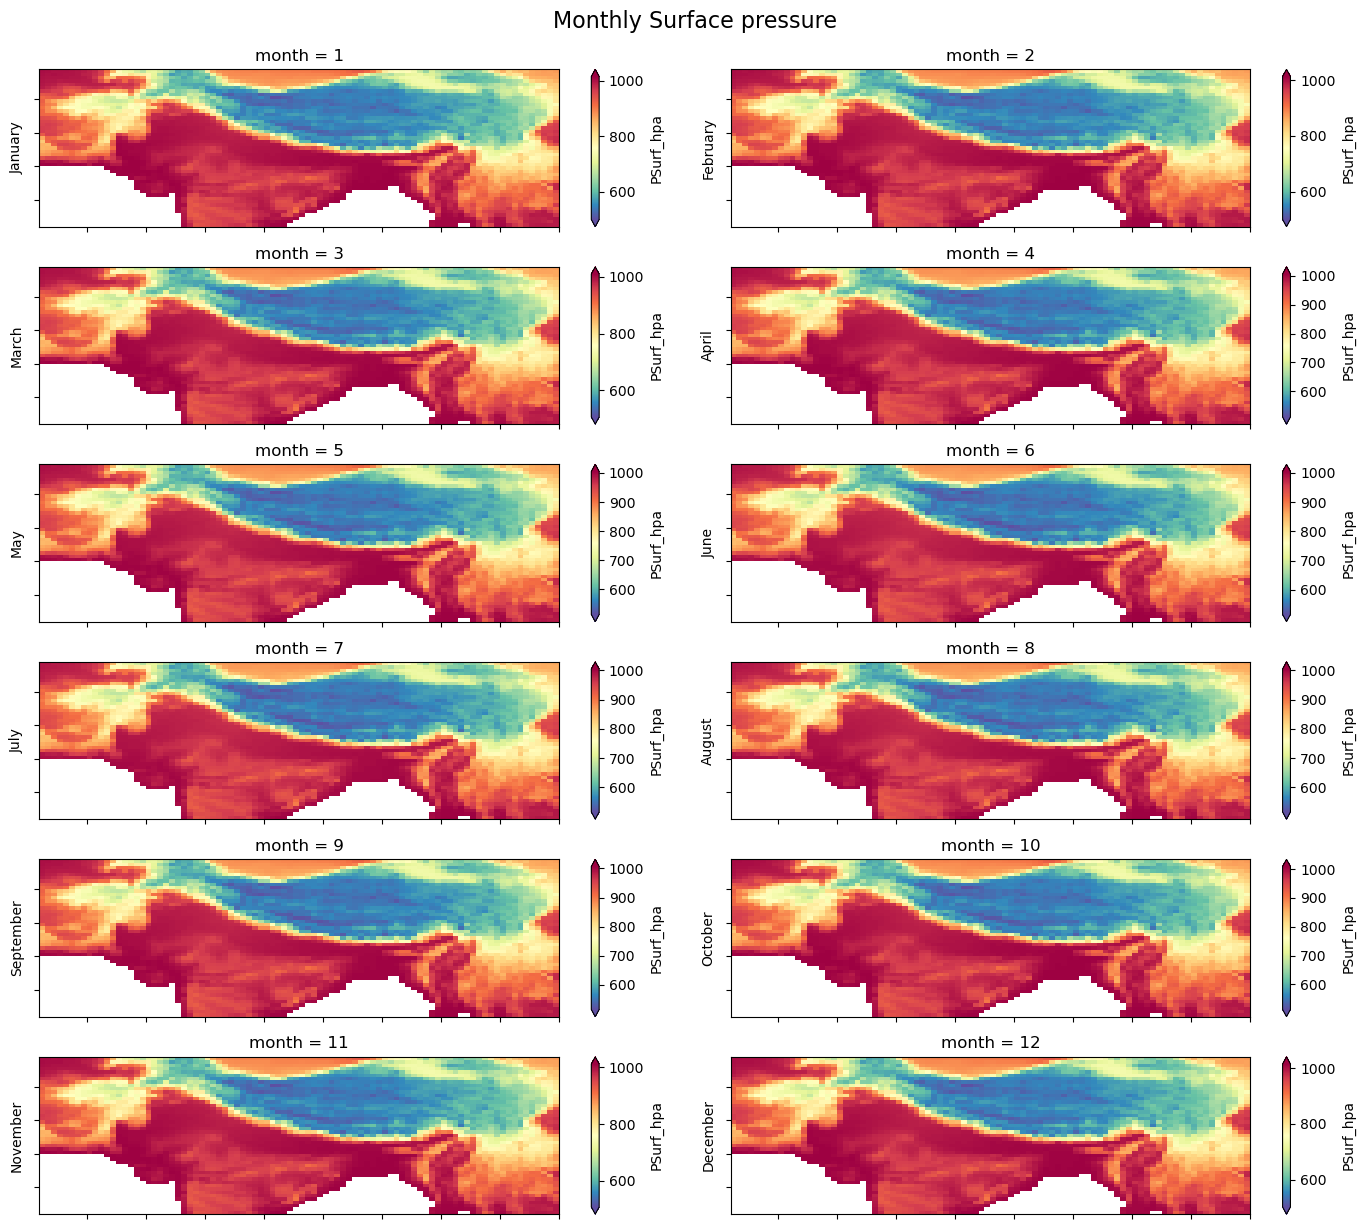

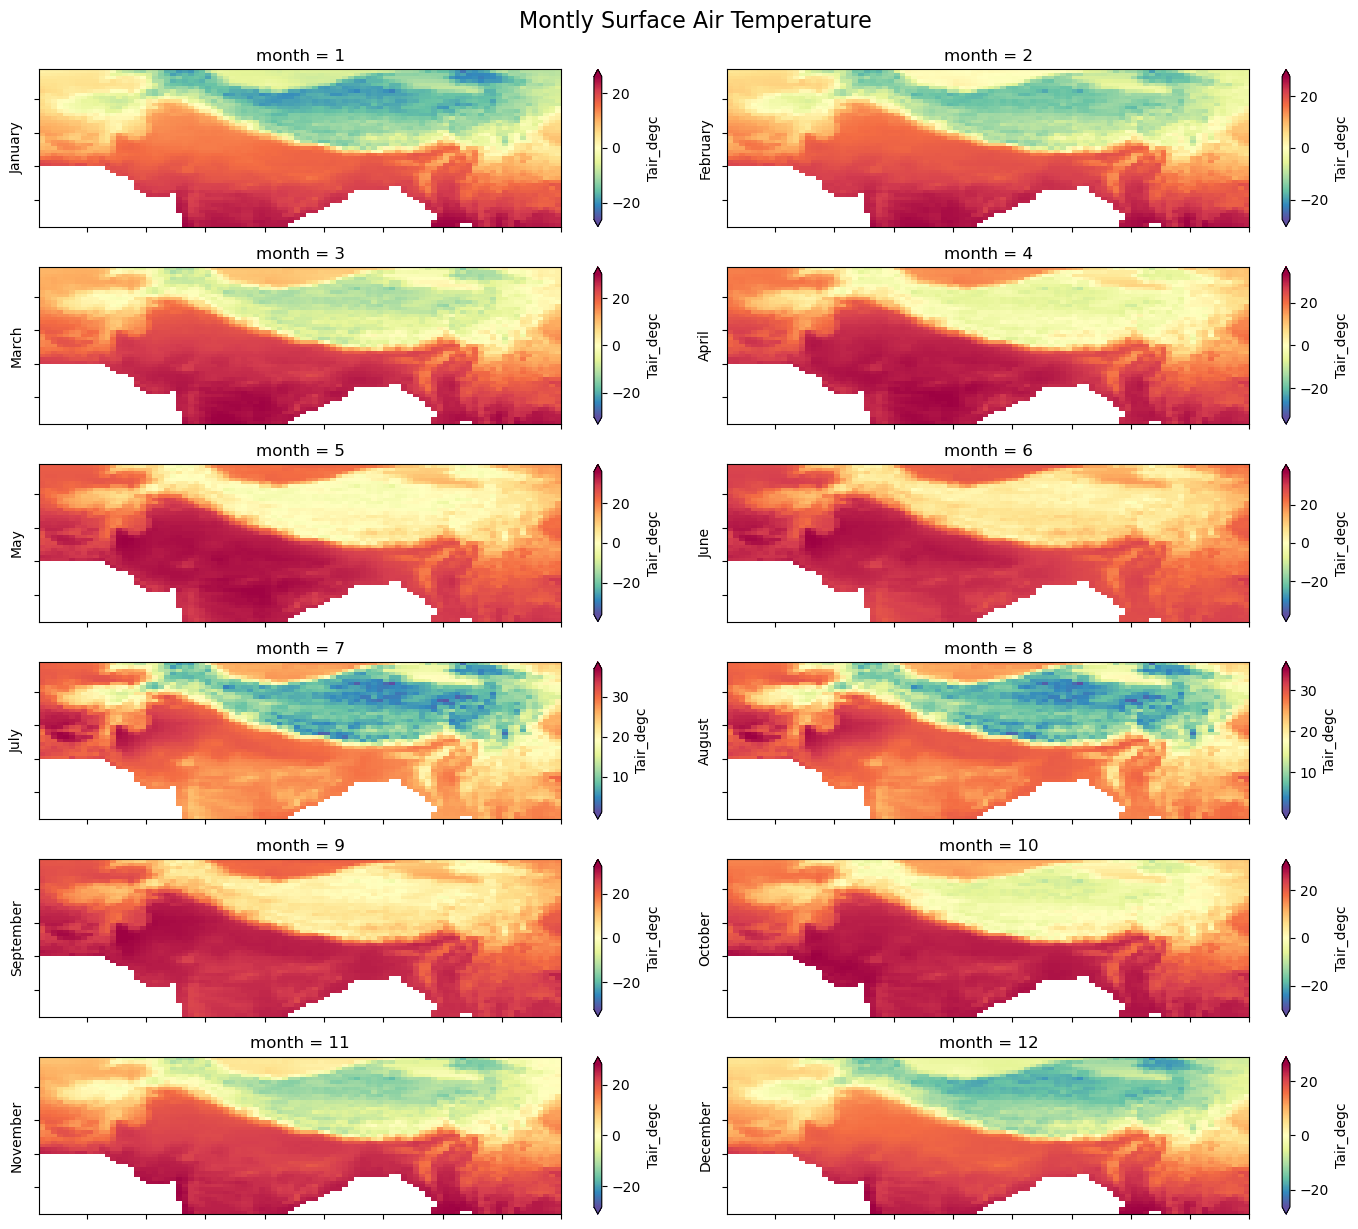

In [9]:
plot_monthly_mean(dataset, variable_names)

## Seasonal mean

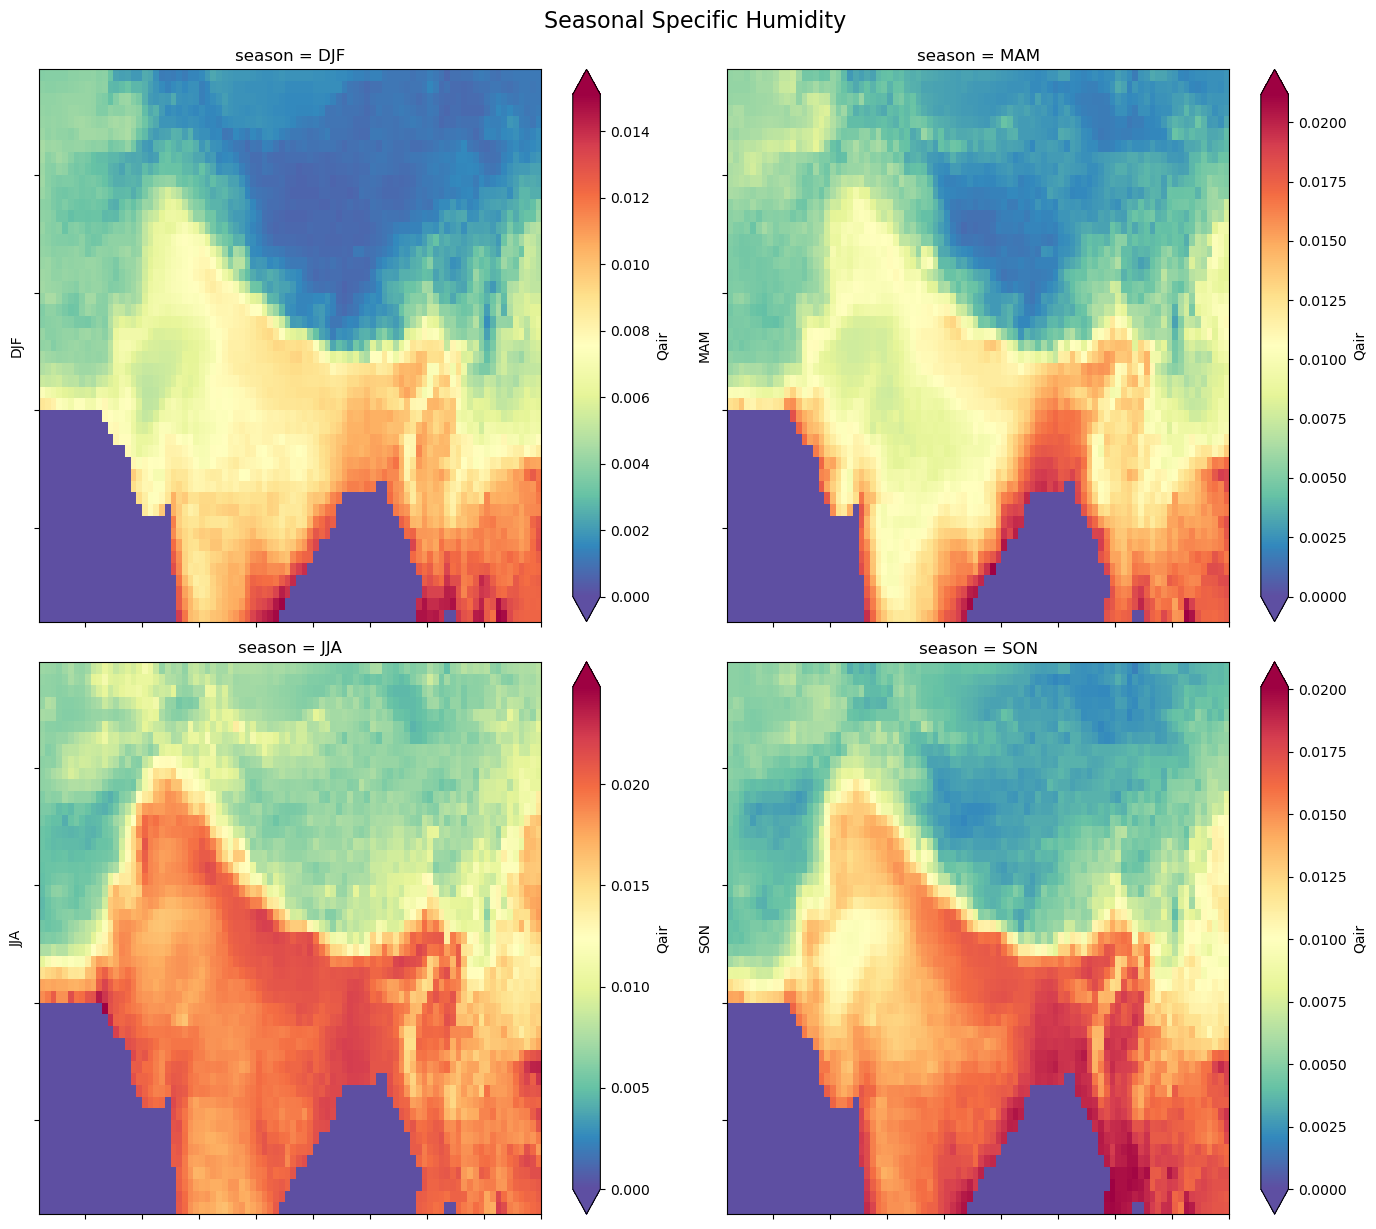

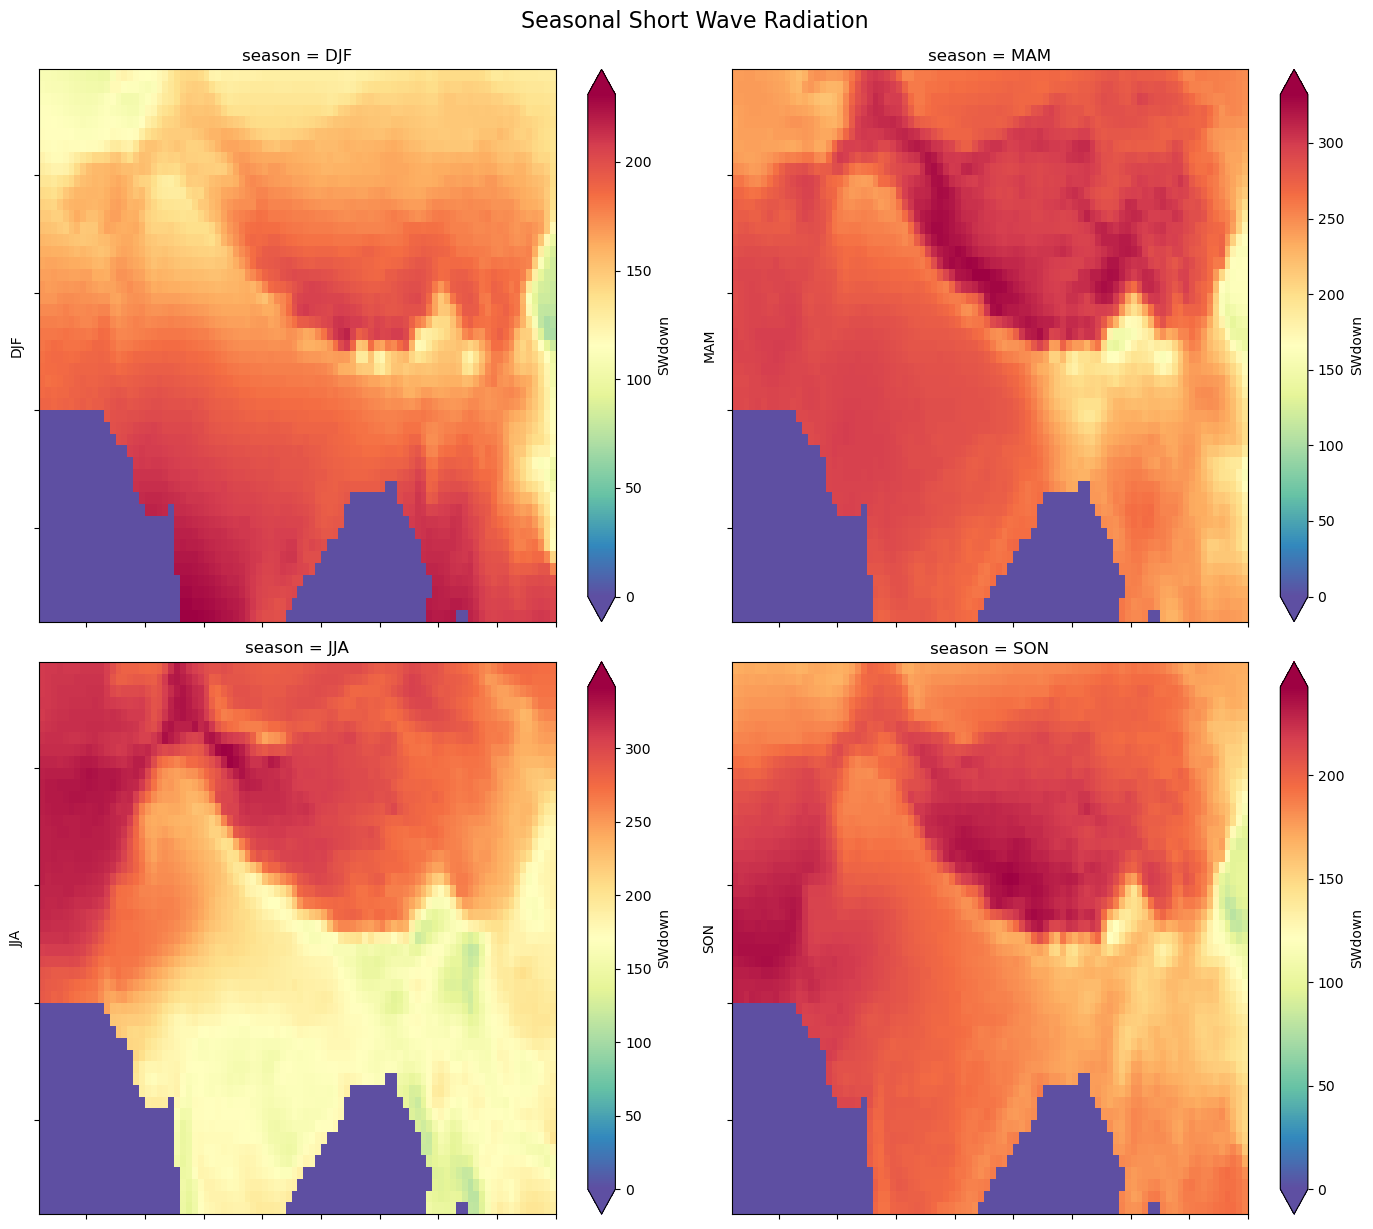

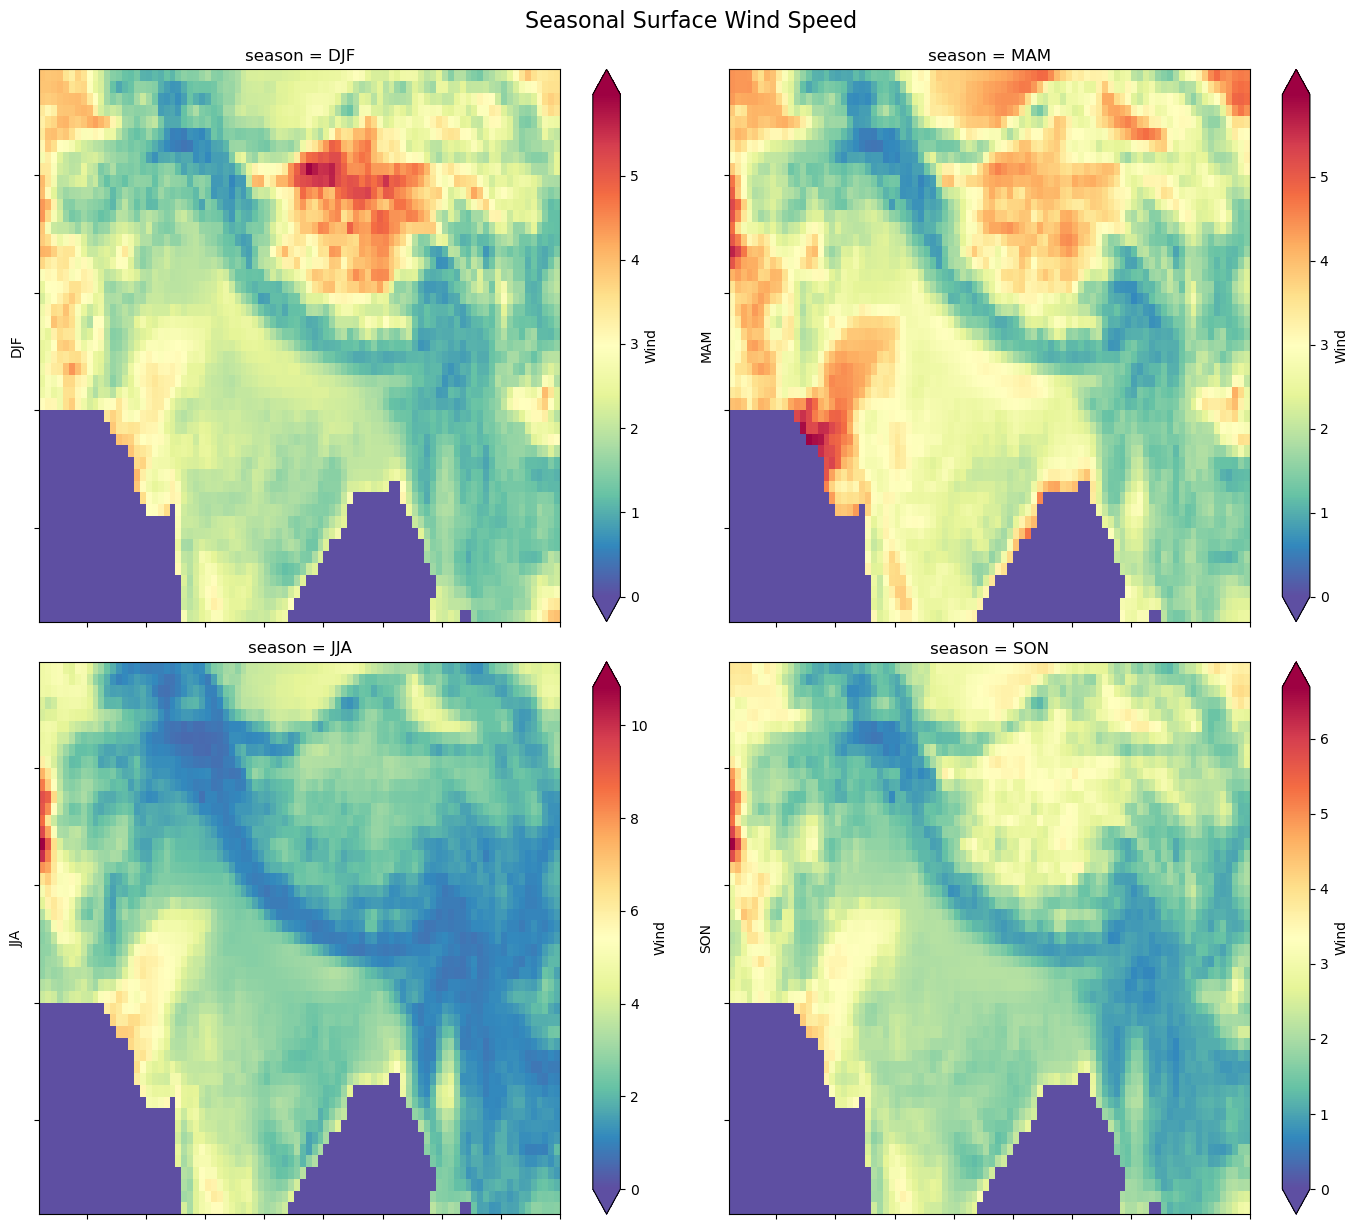

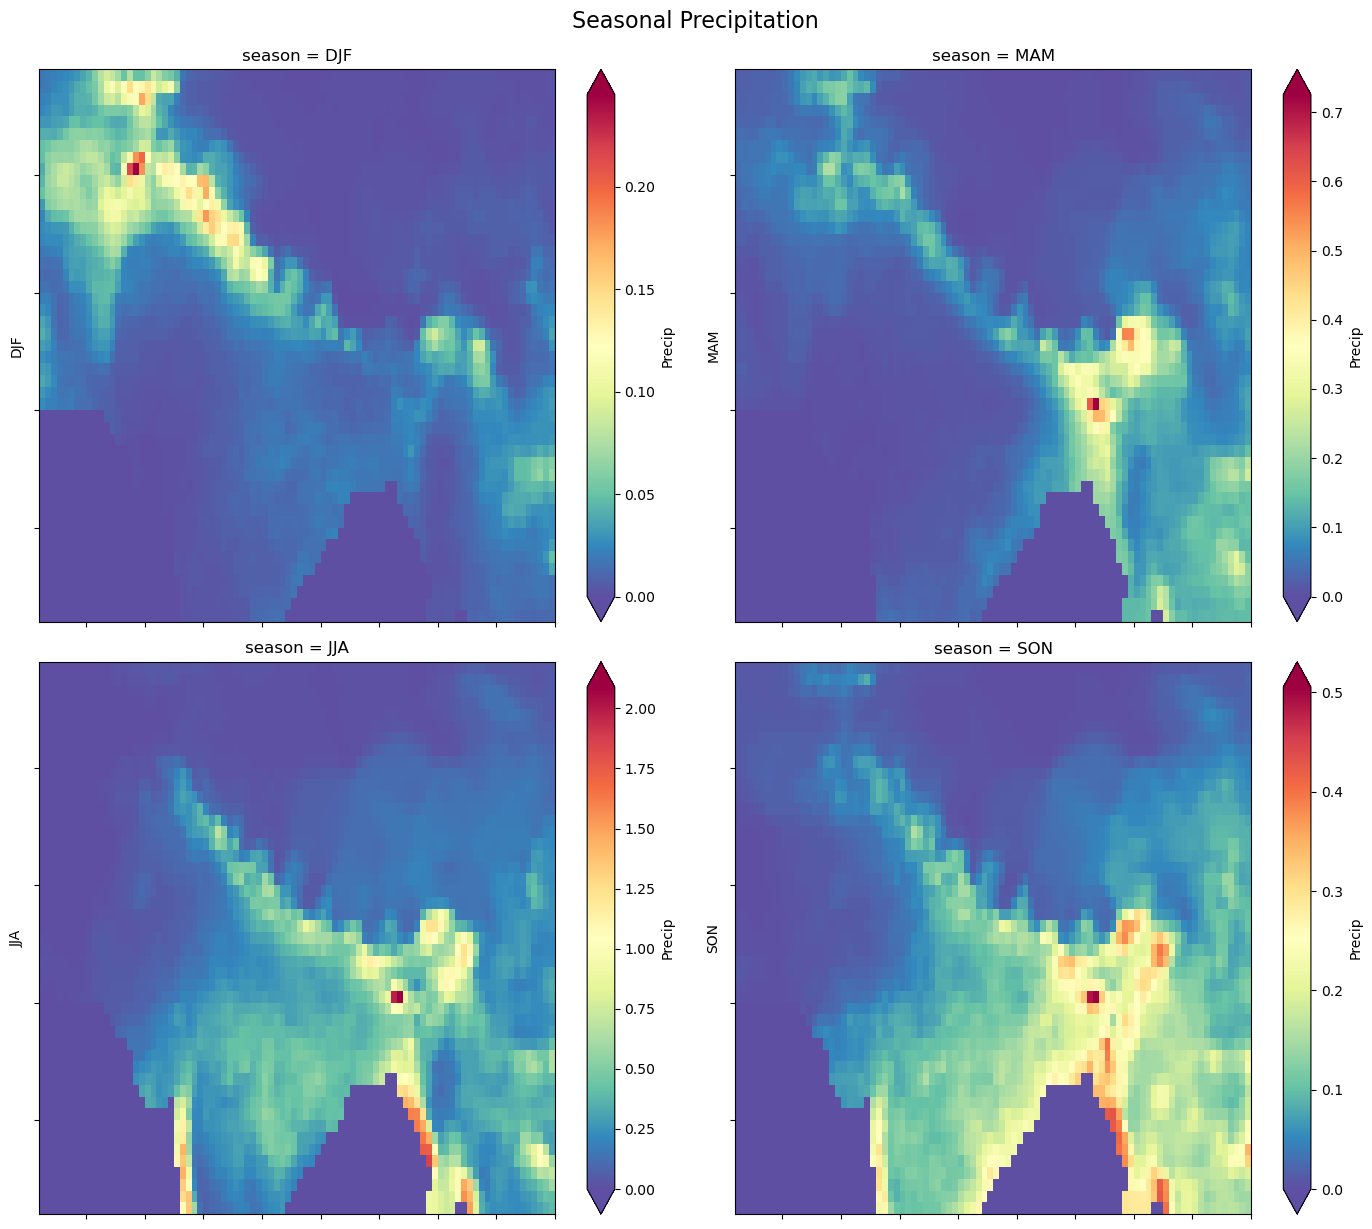

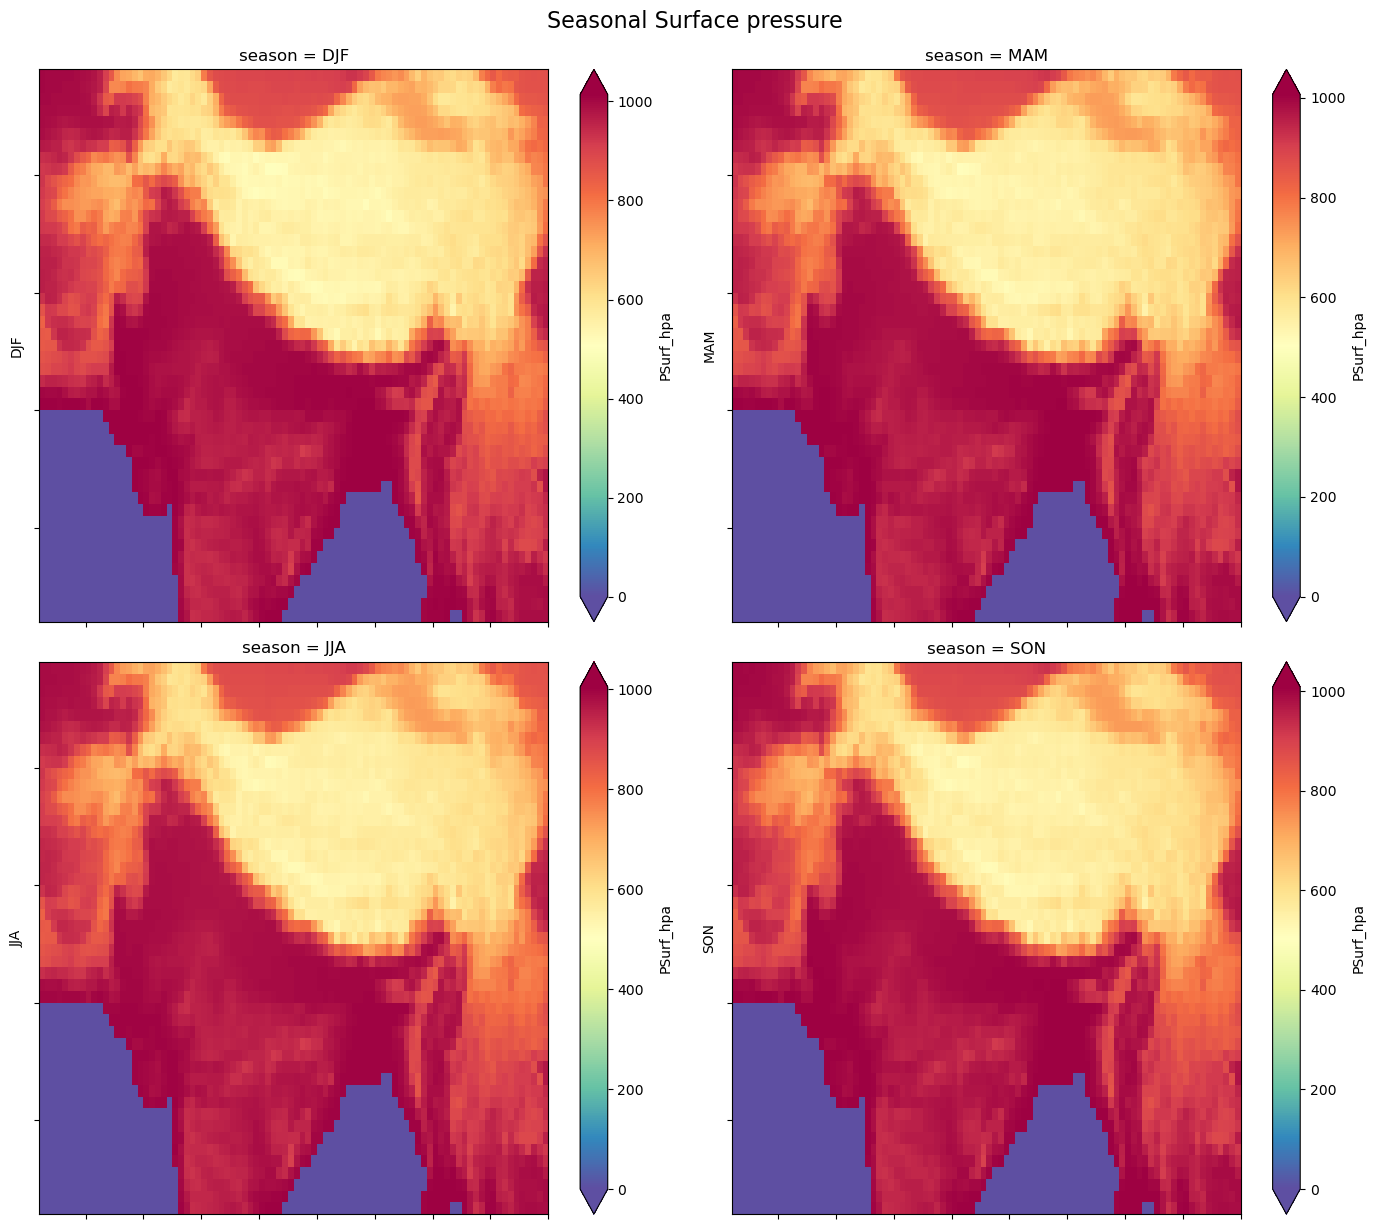

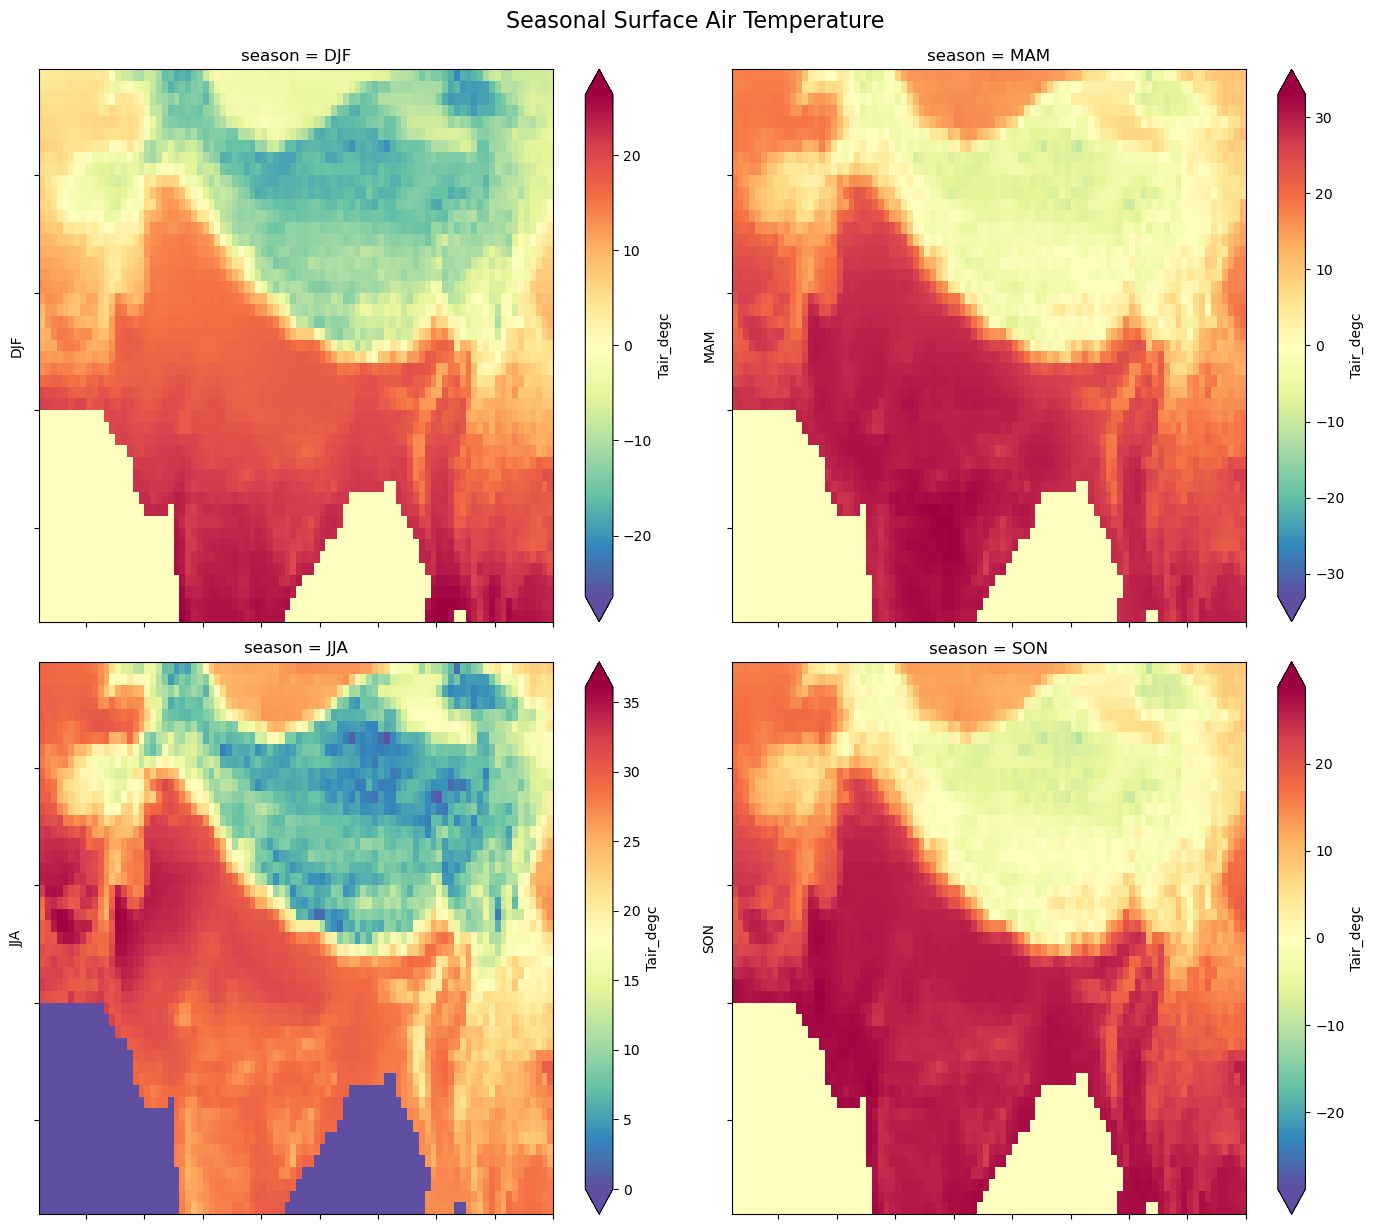

In [10]:
plot_seasonal_mean(dataset, variable_names)

# Exploring data with Pandas and Seaborn

### Variation over time with latitude

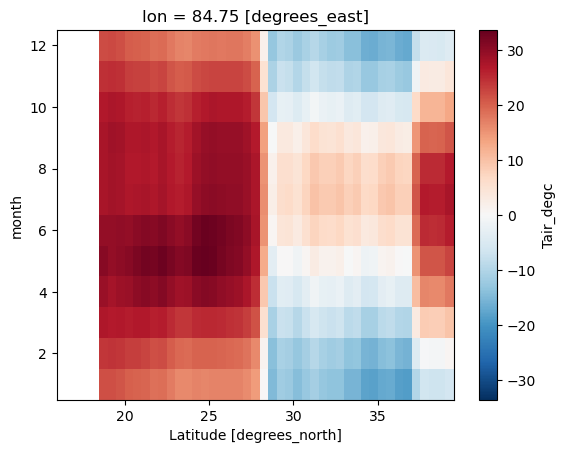

In [17]:
dataset['temperature_degc'].Tair_degc.sel(lon = 84.75).groupby('time.month').mean().plot()

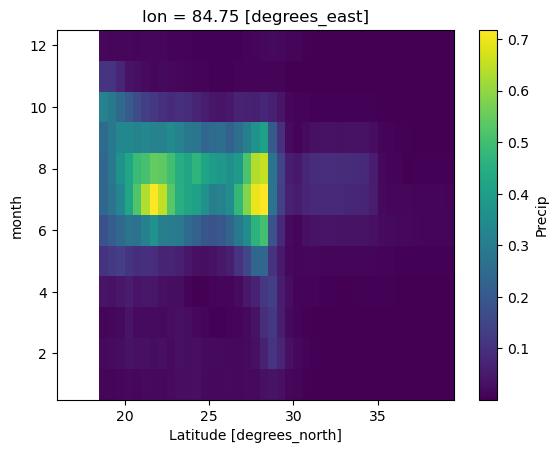

In [25]:
dataset['precipitation_mmh'].Precip.sel(lon = 84.75).groupby('time.month').mean().plot()

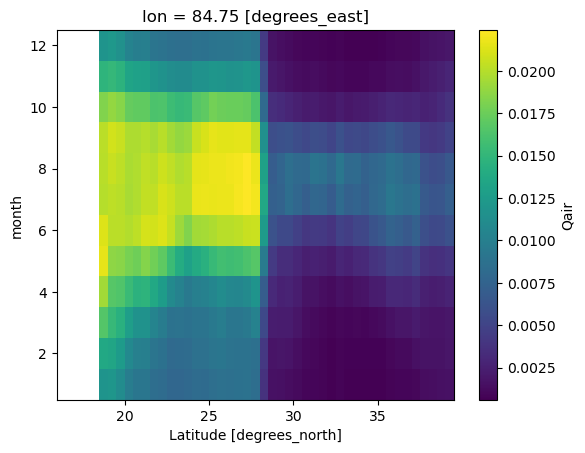

In [21]:
dataset['specific_humidity_kgkg'].Qair.sel(lon = 84.75).groupby('time.month').mean().plot()

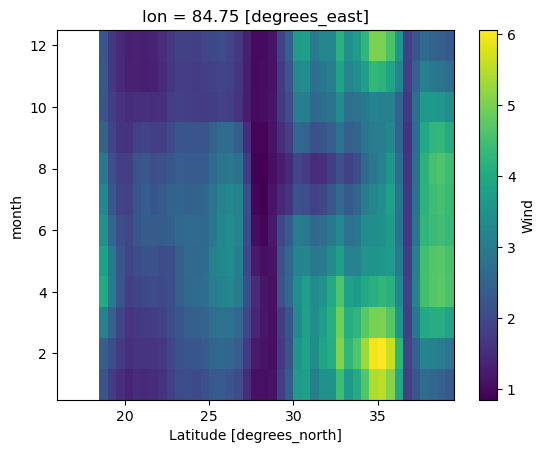

In [23]:
dataset['wind_speed_ms'].Wind.sel(lon = 84.75).groupby('time.month').mean().plot()

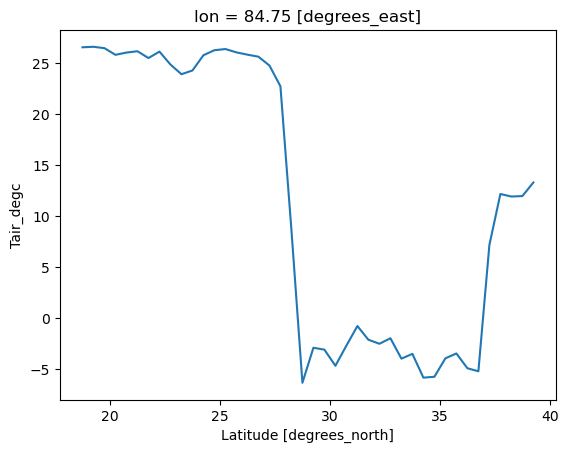

In [41]:
dataset['temperature_degc'].Tair_degc.sel(lon = 84.75).mean(dim = 'time').plot()

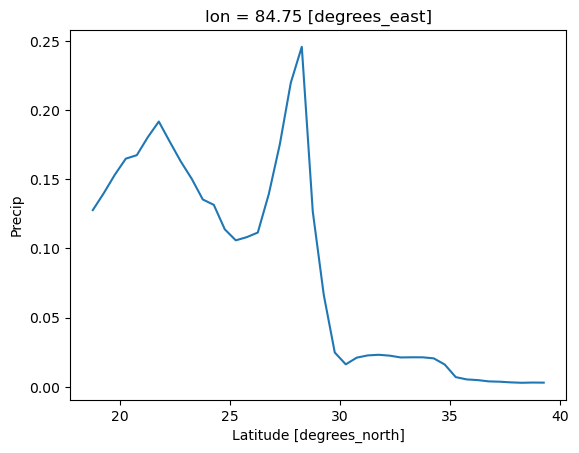

In [35]:
dataset['precipitation_mmh'].Precip.sel(lon = 84.75).mean(dim = 'time').plot()

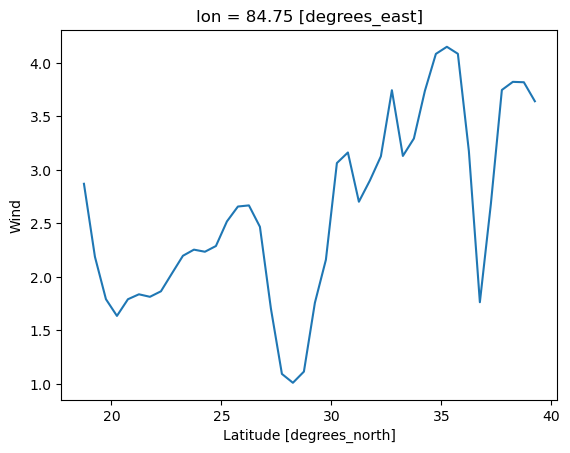

In [33]:
dataset['wind_speed_ms'].Wind.sel(lon = 84.75).mean(dim = 'time').plot()

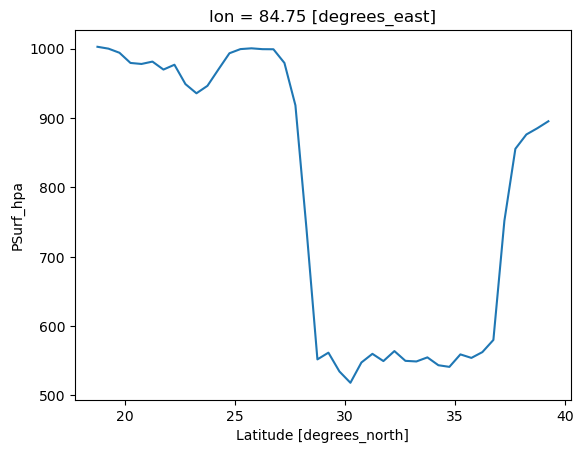

In [34]:
dataset['pressure_hpa'].PSurf_hpa.sel(lon = 84.75).mean(dim = 'time').plot()

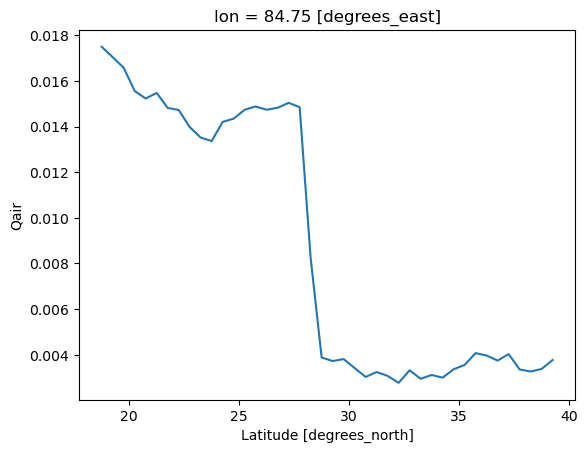

In [36]:
dataset['specific_humidity_kgkg'].Qair.sel(lon = 84.75).mean(dim = 'time').plot()

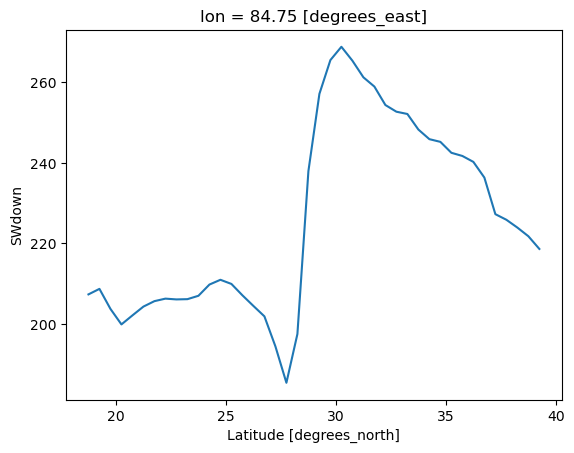

In [31]:
dataset['shortwave_down_wm'].SWdown.sel(lon = 84.75).mean(dim = 'time').plot()

# Correlations

In [142]:
asurf_ds = xr.open_mfdataset(geo_ts.asurf_path)
lats = asurf_ds.lat.values
lons = asurf_ds.lon.values[20:-21]

In [ ]:
# Bounds for Nepal

nepal_west = 79.75
nepal_south = 25.75
neapl_east = 89.25
nepal_north = 31.25

In [141]:
# import requests, json

# try:
#   file=open("test.txt","r+",encoding="utf-8")
#   coordinate=file.readlines() 

# except FileNotFoundError:
#   print("File coordinate.txt not found!")

# apikey="Google Elevation Api Key"

# if apikey=="Google Elevation Api Key":
#         apikey= input ("Please enter your Google Elevation API key, otherwise, the program will not work:")
        
# file.seek(0) #The process of getting to the top line in the txt file
# for latlng in coordinate:
#   serviceURL = "https://maps.googleapis.com/maps/api/elevation/json?locations="+latlng+"&key="+apikey
#   #print(serviceURL)
#   r = requests.get(serviceURL)
#   #print(r.text)
#   y = json.loads(r.text)
#   for result in y["results"]:
#     elev=result["elevation"]
#     file.write((str(latlng.rstrip())+" "+str(elev))+"\n")

# print ("Query completed")
# file.close()

Query completed


In [256]:
temp_mean_df = dataset['temperature_degc'].Tair_degc.mean(dim = 'time').to_dataframe()
precip_mean_df = dataset['precipitation_mmh'].Precip.mean(dim = 'time').to_dataframe()

In [164]:

dem_dataset = rasterio.open('/Users/jacobqs/Documents/MST Himalaya/qgis/DEM/merged_DEM_central_himalaya.tif')

In [166]:
print(dem_dataset.count)
print(dem_dataset.width)
print(dem_dataset.height)

1
10801
18001


In [258]:
lons_temp = []
lats_temp = []
for i in temp_mean_df.index:
    lats_temp.append(i[0])
    lons_temp.append(i[1])
temp_mean_df['lon'] = lons_temp
temp_mean_df['lat'] = lats_temp

lons_precip = []
lats_precip = []
for i in precip_mean_df.index:
    lats_precip.append(i[0])
    lons_precip.append(i[1])
precip_mean_df['lon'] = lons_precip
precip_mean_df['lat'] = lats_precip

In [259]:
temp_mean_df['lat_lon'] = temp_mean_df[['lon', 'lat']].apply(tuple, axis = 1)
temp_mean_df.set_index(np.arange(len(temp_mean_df)), inplace=True)

precip_mean_df['lat_lon'] = precip_mean_df[['lon', 'lat']].apply(tuple, axis = 1)
precip_mean_df.set_index(np.arange(len(precip_mean_df)), inplace=True)

In [260]:
points_temp = []
points_precip = []
for i in range(len(temp_mean_df)):
    points_temp.append(Point(temp_mean_df['lon'][i], temp_mean_df['lat'][i]))
    points_precip.append(Point(precip_mean_df['lon'][i], precip_mean_df['lat'][i]))

In [261]:
gdf_temp = gpd.GeoDataFrame(np.arange(len(temp_mean_df)), geometry = points_temp, crs = 4326)
gdf_precip = gpd.GeoDataFrame(np.arange(len(precip_mean_df)), geometry = points_temp, crs = 4326)

In [262]:
coord_list_temp = [(x,y) for x,y in zip(gdf_temp['geometry'].x , gdf_temp['geometry'].y)]
coord_list_precip = [(x,y) for x,y in zip(gdf_precip['geometry'].x , gdf_precip['geometry'].y)]

In [263]:
gdf_temp['value'] = [x for x in dem_dataset.sample(coord_list_temp)]
gdf_precip['value'] = [x for x in dem_dataset.sample(coord_list_precip)]

In [265]:
temp_mean_df['z'] = np.nan
for i, value in enumerate(gdf_temp['value']):
    temp_mean_df['z'].loc[i] = gdf_temp['value'][i]

precip_mean_df['z'] = np.nan
for i, value in enumerate(gdf_precip['value']):
    precip_mean_df['z'].loc[i] = gdf_precip['value'][i]

/var/folders/07/3pj74xcs7mqdgyzchd88y9840000gn/T/ipykernel_19931/2869708413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_mean_df['z'].loc[i] = gdf_temp['value'][i]
/var/folders/07/3pj74xcs7mqdgyzchd88y9840000gn/T/ipykernel_19931/2869708413.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precip_mean_df['z'].loc[i] = gdf_precip['value'][i]


In [267]:
temp_mean_df_nonzero = temp_mean_df.loc[temp_mean_df['z'] > 0]
precip_mean_df_nonzero = precip_mean_df.loc[precip_mean_df['z'] > 0]

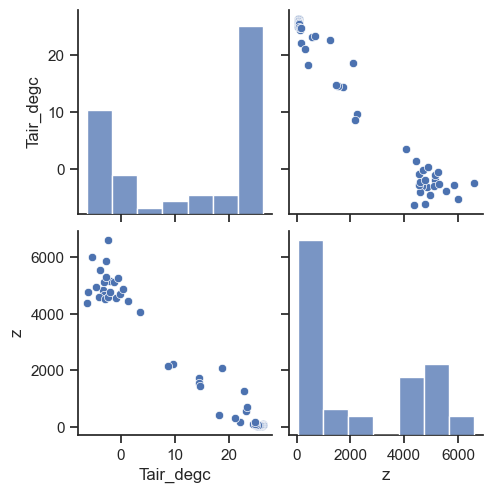

In [214]:
sns.set(style = 'ticks', color_codes = True)
g = sns.pairplot(temp_mean_df_nonzero, vars=['Tair_degc', 'z'])
plt.show()


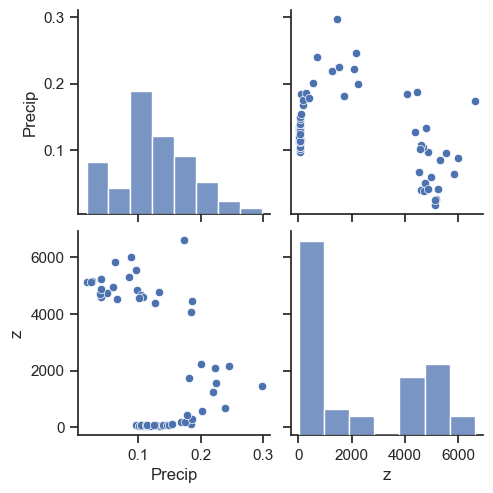

In [268]:
sns.set(style = 'ticks', color_codes = True)
g = sns.pairplot(precip_mean_df_nonzero, vars=['Precip', 'z'])
plt.show()

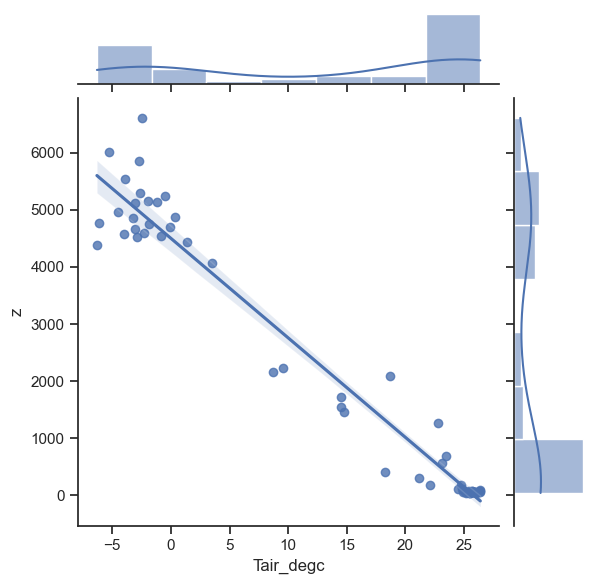

In [228]:
# draw regplot
jp = sns.jointplot(x = "Tair_degc", 
            y = "z", 
            data = temp_mean_df_nonzero,
            kind = 'reg')
  
# show the plot
plt.show()

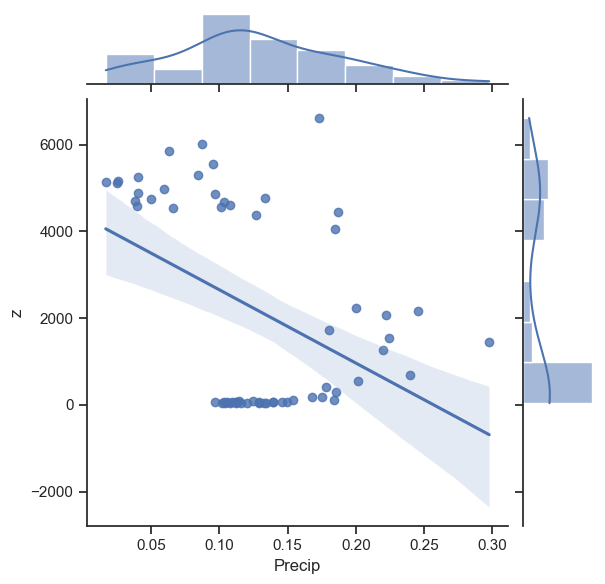

In [269]:
# draw regplot
jp = sns.jointplot(x = "Precip", 
            y = "z", 
            data = precip_mean_df_nonzero,
            kind = 'reg')
  
# show the plot
plt.show()

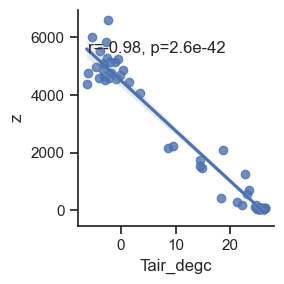

In [218]:

g = sns.lmplot(x='Tair_degc', y='z', data=temp_mean_df_nonzero, height=3, aspect=1)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Tair_degc'], data['z'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

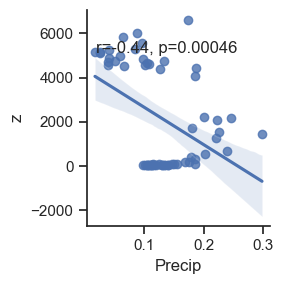

In [270]:
g = sns.lmplot(x='Precip', y='z', data=precip_mean_df_nonzero, height=3, aspect=1)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Precip'], data['z'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

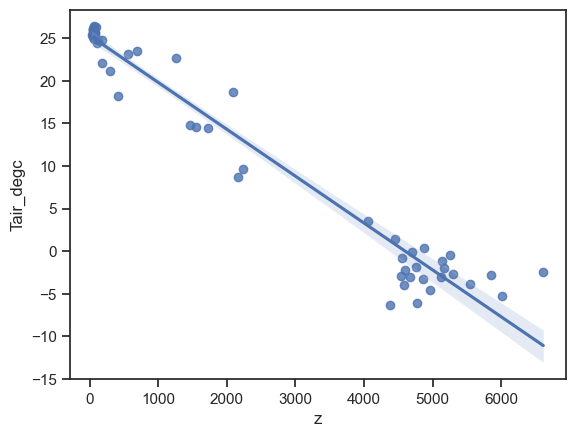

In [238]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
p = sns.regplot(x= 'z',y= 'Tair_degc',data=temp_mean_df_nonzero,ax=ax)
p.get_lines()[0].get_xdata()
p.get_lines()[0].get_ydata()
plt.show()

In [245]:
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())

In [279]:
print(f'Temperature Lapse Rate: {np.round(intercept,0)}{np.round(slope,5)}X with an R of {r_value} and a standard error of {std_err}')

Temperature Lapse Rate: 0.0-1e-05X with an R of -1.0 and a standard error of 0.0


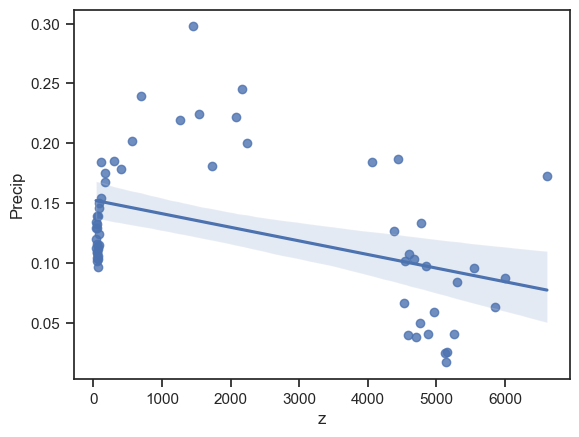

In [271]:
f = plt.figure()
ax = f.add_subplot(1,1,1)
p = sns.regplot(x= 'z',y= 'Precip',data=precip_mean_df_nonzero,ax=ax)
p.get_lines()[0].get_xdata()
p.get_lines()[0].get_ydata()
plt.show()

In [272]:
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())

In [278]:
print(f'Precipitation Lapse Rate: {np.round(intercept,5)}{np.round(slope,6)}X with an R value of {r_value} and a standard error of {std_err}')

Precipitation Lapse Rate: 0.15263-1.1e-05X with an R value of -1.0 and a standard error of 0.0


In [219]:
temp_mean_df_nonzero.describe()

,Tair_degc,lon,lat,z
count,60.000000,60.000000,60.00000,60.000000
mean,13.288095,85.500000,27.50000,2184.533333
std,13.042070,0.861119,1.44826,2321.409117
min,-6.305935,84.250000,25.25000,40.000000
25%,-1.924882,84.750000,26.25000,64.500000
50%,19.936996,85.500000,27.50000,973.500000
75%,25.432861,86.250000,28.75000,4675.750000
max,26.382702,86.750000,29.75000,6612.000000
